# Skin Cancer Classification kNN Analysis

Importing required libraries and splitting features and labels as well as training and test data. In the dataset it used its own split ratio, as 16800 training instance and 4192 test instance. Hence, the split ratio is 0.8 for training data and 0.2 test data. From that we will split the training data into 0.7 train, 0.1 validation.

In [1]:
import pandas as pd
import numpy as np

def load_dataset():

  splits = {'train': 'balanced_skin_cancer_dataset_train_2.parquet', 'test': 'balanced_skin_cancer_dataset_test.parquet'}
  # Load train dataset
  train_df = pd.read_parquet("hf://datasets/akinsanyaayomide/skin_cancer_dataset_balanced_labels/" + splits["train"])
  train_arr = train_df.values
  train_x = train_arr[:, :-1]
  train_y = train_arr[:, -1]

  # Load test dataset
  test_df = pd.read_parquet("hf://datasets/akinsanyaayomide/skin_cancer_dataset_balanced_labels/" + splits["test"])
  test_arr = test_df.values
  test_x = test_arr[:, :-1]
  test_y = test_arr[:, -1]

  return train_x, train_y, test_x, test_y

Test for loading the dataset.

In [2]:
train_x, train_y, test_x, test_y = load_dataset()

print('Training dataset X shape:', train_x.shape)
print('Training dataset Y shape:', train_y.shape)
print('Test dataset X shape:', test_x.shape)
print('Test dataset Y shape:', test_y.shape)
print('An instance in the training dataset:', train_x[0], train_y[0])
print('An instance in the test dataset:', test_x[0], test_y[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Training dataset X shape: (16800, 1)
Training dataset Y shape: (16800,)
Test dataset X shape: (4192, 1)
Test dataset Y shape: (4192,)
An instance in the training dataset: [{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\xe0\x00\xe0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x8

In [3]:
def train_val_split(train_x, train_y, val_size=0.125, random_state=464):
    """
    Manually splits the training data into a training and validation set.

    Parameters:
    -----------
    train_x : np.ndarray
        Feature matrix of the training data.

    train_y : np.ndarray
        Labels for the training data.

    val_size : float
        Proportion of the training data to be used as validation set.

    random_state : int
        Random seed for reproducibility.

    Returns:
    --------
    X_train, X_val, y_train, y_val : np.ndarray
        Training and validation splits of the features and labels.
    """
    np.random.seed(random_state)

    indices = np.arange(train_x.shape[0])
    np.random.shuffle(indices)

    split_index = int((1 - val_size) * len(indices))

    X_train, X_val = train_x[indices[:split_index]], train_x[indices[split_index:]]
    y_train, y_val = train_y[indices[:split_index]], train_y[indices[split_index:]]

    return X_train, X_val, y_train, y_val

In [4]:
from PIL import Image
import io
from sklearn.decomposition import PCA

def bytes_to_image_array(byte_data):
    """
    Decodes byte data to a flattened grayscale pixel array of target size.
    """
    image = Image.open(io.BytesIO(byte_data))
    return np.array(image).flatten() / 255.0  # Normalize to [0, 1]

def calc_distance_matrix(train_bytes, test_bytes, n_components=100):
    """
    Calculates the Euclidean distance matrix between test and training samples.
    Applies PCA for dimensionality reduction.
    """
    # Convert byte data to flattened image arrays
    X_train = np.array([bytes_to_image_array(b[0]["bytes"]) for b in train_bytes])
    X_test = np.array([bytes_to_image_array(b[0]["bytes"]) for b in test_bytes])

    # Apply PCA to reduce dimensions
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Calculate the Euclidean distance matrix in the reduced PCA space
    distances = np.sqrt(((X_test_pca[:, np.newaxis, :] - X_train_pca[np.newaxis, :, :]) ** 2).sum(axis=2))
    return distances

In [5]:
def get_neighbors(train_X, train_Y, test_instance, k, distance_matrix=None, test_index=0):
    """
    Finds the k nearest neighbors of a given test instance using the distance matrix.
    """
    if distance_matrix is not None:
        # Use the precomputed distance matrix if available
        distances = distance_matrix[test_index]
    else:
        # Compute distances directly if not using a matrix
        distances = np.linalg.norm(train_X - test_instance, axis=1)

    # Get sorted indices and retrieve the k closest classes
    sorted_indexes = np.argsort(distances)
    sorted_classes = train_Y[sorted_indexes]
    return sorted_classes[:k]

In [6]:
def classify(neighbors_classes):
    """
    Determines the most occuring label among the neighboring data points.

    Parameters:
    -----------
    neighbors_classes : list
        A list of class labels for the nearest neighbors of a given test point.

    Returns:
    --------
    most_voted_class : object
        The class label with the highest number of votes among the neighbors.
        If there is a tie, the first encountered class with the highest count is returned.
    """
    class_votes = {cls: 0 for cls in neighbors_classes}
    for cls in neighbors_classes:
        class_votes[cls] += 1
    most_vote_count = 0
    most_voted_class = None
    for cls in class_votes:
        if class_votes[cls] > most_vote_count:
            most_voted_class = cls
            most_vote_count = class_votes[cls]
    return most_voted_class

In [7]:
class KNN:
    """
    K-Nearest Neighbors (KNN) classifier with distance matrix.
    """
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, train_x, train_y):
        self.train_X = train_x
        self.train_y = train_y

    def predict(self, test_x):
        # Compute distance matrix between all test and training samples
        distance_matrix = calc_distance_matrix(self.train_X, test_x)

        predictions = []
        for test_index, _ in enumerate(test_x):
            neighbors_classes = get_neighbors(self.train_X, self.train_y, test_x[test_index],
                                              self.n_neighbors, distance_matrix, test_index)
            predicted_label = classify(neighbors_classes)
            predictions.append(predicted_label)

        return predictions

Testing kNN for the image data. We first load the dataset and set training data and test data as well as features and labels. Then we split the training data 0.7 train and 0.1 validation approximately. Then from k = 1, 3, ..., 9 we choose the best three k values as our metric for the performances that will be used on the test data.

In [8]:
train_x, train_y, test_x, test_y = load_dataset()
X_train, X_val, y_train, y_val = train_val_split(train_x, train_y)

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

Validation Accuracy for K=1: 48.714%
Validation Accuracy for K=3: 48.429%
Validation Accuracy for K=5: 47.238%
Validation Accuracy for K=7: 46.810%
Validation Accuracy for K=9: 46.143%

K values above the threshold of 0.46: [1, 3, 5, 7, 9]

K=1 | Test Accuracy: 49.690%
Confusion Matrix for K = 1:
 [[201  79  59  55  18  36  51  25]
 [ 38 283  77  18  30  39  23  16]
 [ 29 107 238  18  42  63  11  16]
 [ 30  31  18 355  11  24  26  29]
 [ 29  53 103  23 153 130  14  19]
 [ 10  50  79  26  57 269   9  24]
 [ 74  51  50  63  15  35 193  43]
 [ 17  19  18  35  10  20  14 391]]
Classification Report for K = 1:
               precision    recall  f1-score   support

           0       0.47      0.38      0.42       524
           1       0.42      0.54      0.47       524
           2       0.37      0.45      0.41       524
           3       0.60      0.68      0.64       524
           4       0.46      0.29      0.36       524
           5       0.44      0.51      0.47       524
       

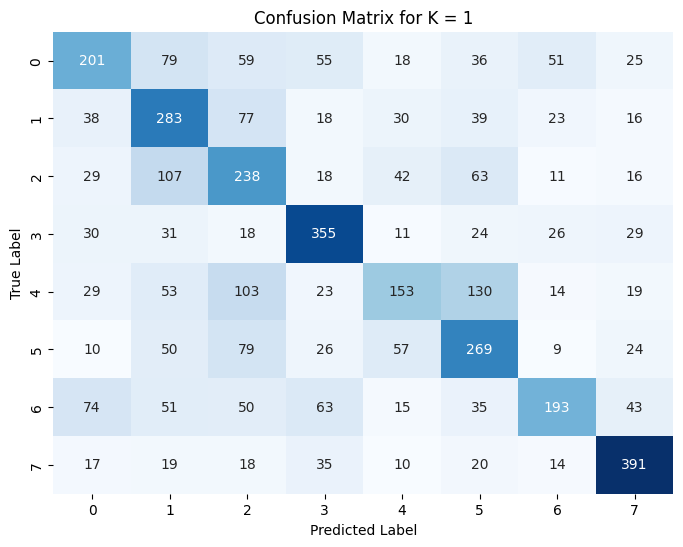

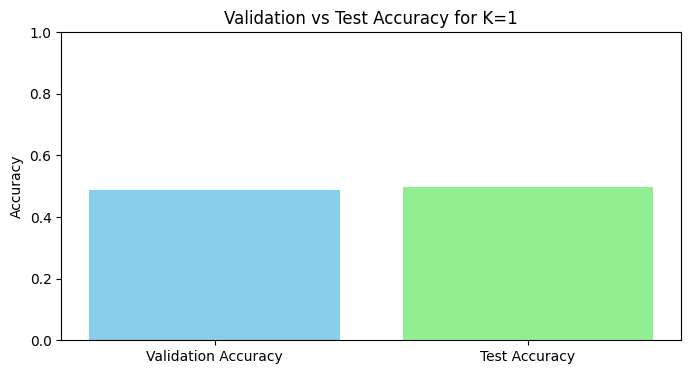


K=3 | Test Accuracy: 48.092%
Confusion Matrix for K = 3:
 [[189  94  65  54  16  32  51  23]
 [ 31 303  78  18  25  37  21  11]
 [ 28 120 228  21  39  63  12  13]
 [ 38  39  21 336   8  27  28  27]
 [ 20  58 120  23 139 133  14  17]
 [  9  44  82  20  57 278   9  25]
 [ 76  65  56  72  11  42 165  37]
 [ 15  20  17  41  11  30  12 378]]
Classification Report for K = 3:
               precision    recall  f1-score   support

           0       0.47      0.36      0.41       524
           1       0.41      0.58      0.48       524
           2       0.34      0.44      0.38       524
           3       0.57      0.64      0.61       524
           4       0.45      0.27      0.33       524
           5       0.43      0.53      0.48       524
           6       0.53      0.31      0.39       524
           7       0.71      0.72      0.72       524

    accuracy                           0.48      4192
   macro avg       0.49      0.48      0.47      4192
weighted avg       0.49      0

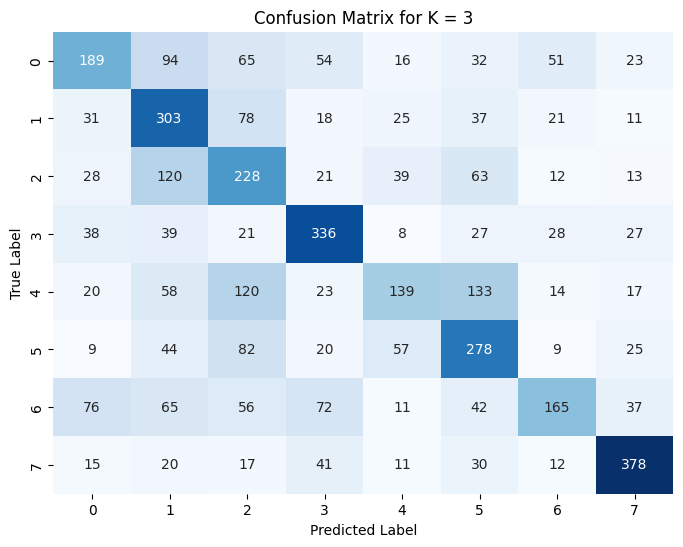

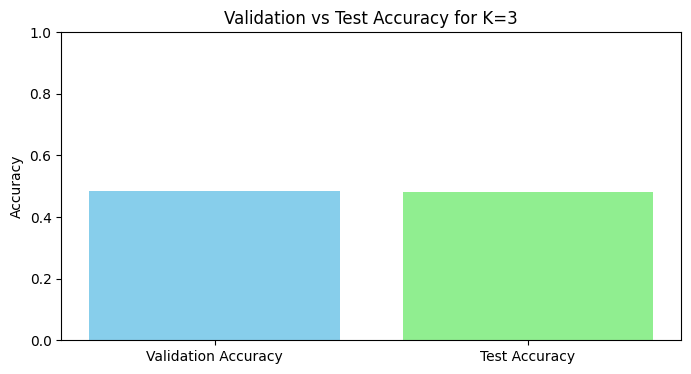


K=5 | Test Accuracy: 47.758%
Confusion Matrix for K = 5:
 [[177 120  63  49  15  32  46  22]
 [ 29 338  81   9  19  30  11   7]
 [ 20 137 220  20  32  72  12  11]
 [ 34  37  27 340   5  24  34  23]
 [ 11  72 127  20 119 141  12  22]
 [  7  53  85  15  48 286   9  21]
 [ 72  87  61  68  10  43 147  36]
 [ 18  22  20  36  12  30  11 375]]
Classification Report for K = 5:
               precision    recall  f1-score   support

           0       0.48      0.34      0.40       524
           1       0.39      0.65      0.49       524
           2       0.32      0.42      0.36       524
           3       0.61      0.65      0.63       524
           4       0.46      0.23      0.30       524
           5       0.43      0.55      0.48       524
           6       0.52      0.28      0.36       524
           7       0.73      0.72      0.72       524

    accuracy                           0.48      4192
   macro avg       0.49      0.48      0.47      4192
weighted avg       0.49      0

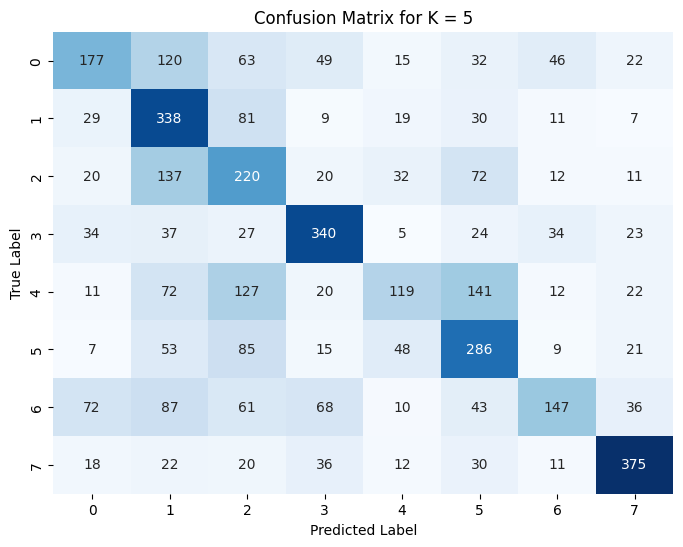

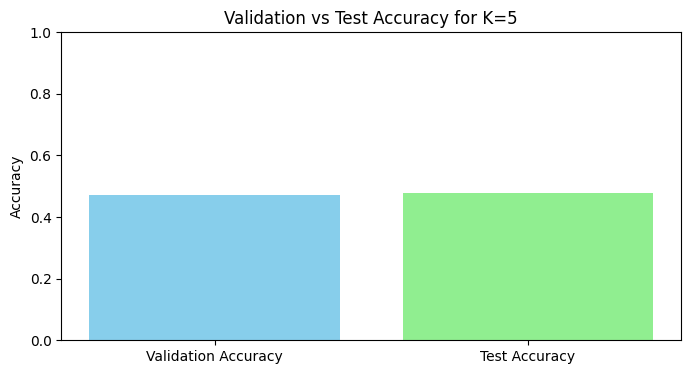


K=7 | Test Accuracy: 46.875%
Confusion Matrix for K = 7:
 [[175 127  65  52  13  30  38  24]
 [ 21 347  88   7  20  25   9   7]
 [ 14 148 238  13  27  69   5  10]
 [ 37  41  26 331   6  29  23  31]
 [ 12  77 136  15 106 149   6  23]
 [  5  56  86  17  46 287   4  23]
 [ 80  95  62  67  13  44 120  43]
 [ 17  27  22  39   9  35  14 361]]
Classification Report for K = 7:
               precision    recall  f1-score   support

           0       0.48      0.33      0.40       524
           1       0.38      0.66      0.48       524
           2       0.33      0.45      0.38       524
           3       0.61      0.63      0.62       524
           4       0.44      0.20      0.28       524
           5       0.43      0.55      0.48       524
           6       0.55      0.23      0.32       524
           7       0.69      0.69      0.69       524

    accuracy                           0.47      4192
   macro avg       0.49      0.47      0.46      4192
weighted avg       0.49      0

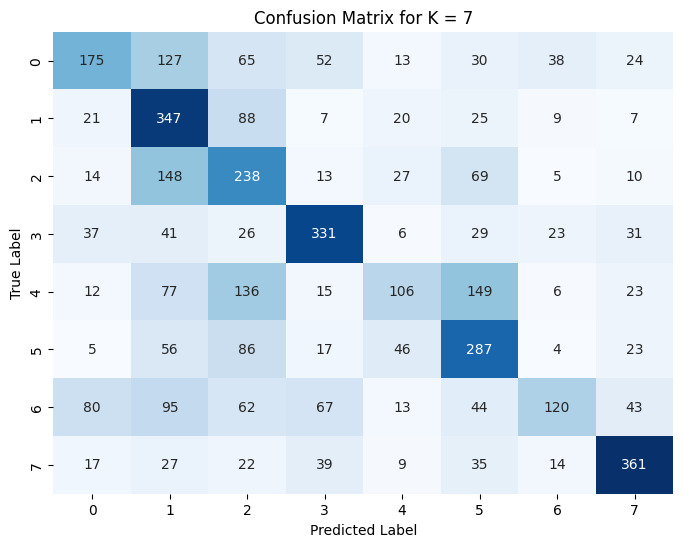

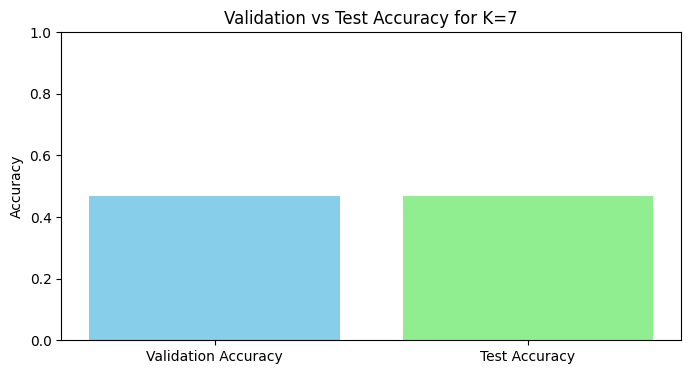


K=9 | Test Accuracy: 46.231%
Confusion Matrix for K = 9:
 [[177 132  66  51  11  27  38  22]
 [ 17 360  92   4  15  22   6   8]
 [ 18 160 220  14  25  74   5   8]
 [ 43  37  30 329   7  26  24  28]
 [ 10  81 134  15 104 154   4  22]
 [  5  57  84  21  41 284   4  28]
 [ 85 100  60  79  10  46 106  38]
 [ 17  25  23  42  11  39   9 358]]
Classification Report for K = 9:
               precision    recall  f1-score   support

           0       0.48      0.34      0.40       524
           1       0.38      0.69      0.49       524
           2       0.31      0.42      0.36       524
           3       0.59      0.63      0.61       524
           4       0.46      0.20      0.28       524
           5       0.42      0.54      0.47       524
           6       0.54      0.20      0.29       524
           7       0.70      0.68      0.69       524

    accuracy                           0.46      4192
   macro avg       0.49      0.46      0.45      4192
weighted avg       0.49      0

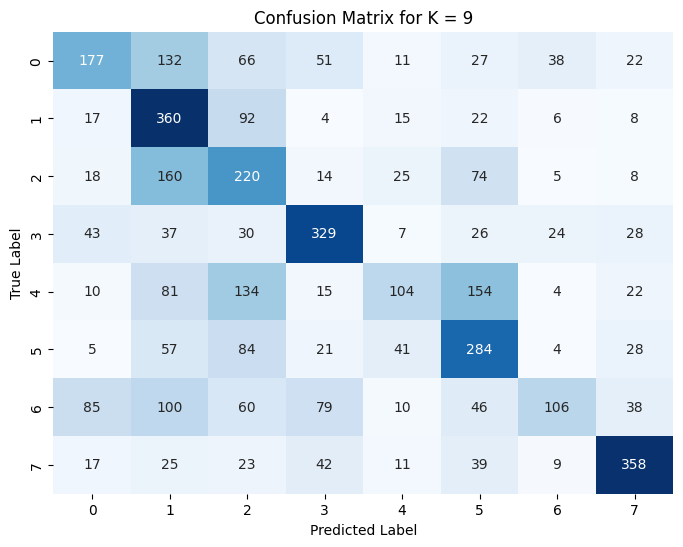

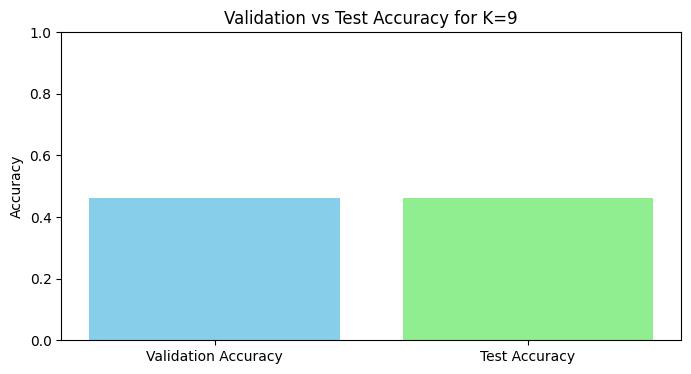

In [10]:
k_values = range(1, 10, 2)
validation_scores = {}

test_y = test_y.astype(int)
y_val = y_val.astype(int)

THRESHOLD = 0.46

for k in k_values:
    knn = KNN(n_neighbors=k)
    knn.fit(X_train, y_train)
    val_pred_y = knn.predict(X_val)

    val_accuracy = accuracy_score(y_val, val_pred_y)
    validation_scores[k] = val_accuracy
    print(f"Validation Accuracy for K={k}: {val_accuracy * 100:.3f}%")

top_k = [k for k, score in validation_scores.items() if score > THRESHOLD]
print("\nK values above the threshold of {:.2f}:".format(THRESHOLD), top_k)

for k in top_k:
    knn = KNN(n_neighbors=k)
    knn.fit(train_x, train_y)
    pred_y = knn.predict(test_x)

    test_accuracy = accuracy_score(test_y, pred_y)
    print("\nK={} | Test Accuracy: {:.3f}%".format(k, test_accuracy * 100))

    conf_matrix = confusion_matrix(test_y, pred_y)
    print("Confusion Matrix for K = {}:\n".format(k), conf_matrix)

    print("Classification Report for K = {}:\n".format(k), classification_report(test_y, pred_y))

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=np.unique(test_y), yticklabels=np.unique(test_y))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for K = {}".format(k))
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.bar(['Validation Accuracy', 'Test Accuracy'], [validation_scores[k], test_accuracy], color=['skyblue', 'lightgreen'])
    plt.ylim(0, 1)
    plt.ylabel('Accuracy')
    plt.title(f'Validation vs Test Accuracy for K={k}')
    plt.show()